In [1]:
# =============================================================================
# Multi-Objective Genetic Algorithm (NSGA-II) for a Materials Science Application
#
# In materials science and chemistry, design optimization often involves trade-offs
# between conflicting objectives. For example, one might aim to minimize the deviation
# from an ideal high-performance design while simultaneously minimizing production cost.
#
# In this example, we simulate a multi-objective optimization problem where the design
# variables are two parameters (x and y), with the following objective functions:
#
#   f1(x, y) = (x - 3)^2 + (y - 3)^2    --> Represents deviation from an ideal high-performance target.
#   f2(x, y) = (x - 7)^2 + (y - 7)^2    --> Represents deviation from an ideal low-cost target.
#
# The goal is to minimize both f1 and f2 simultaneously. Since these objectives are conflicting,
# there is no single optimum; instead, a Pareto front of trade-off solutions is expected.
#
# We implement a simplified NSGA-II algorithm:
#   1. Initialize a random population of candidate solutions.
#   2. Evaluate objective values for each candidate.
#   3. Perform non-dominated sorting to assign Pareto ranks.
#   4. Calculate crowding distance to ensure diversity.
#   5. Use tournament selection based on rank and crowding distance.
#   6. Apply crossover and mutation to generate offspring.
#   7. Combine parent and offspring populations and select the next generation.
#
# We then visualize the final Pareto front in the objective space and the distribution in the
# decision space (x, y). This example is applicable to multi-objective optimization in materials design.
# =============================================================================

In [2]:

# -----------------------------------------------------------------------------
# 1. Import Libraries and Set Up Environment
# -----------------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings

warnings.filterwarnings('ignore')
sns.set(style='whitegrid')
np.random.seed(42)
random.seed(42)


In [3]:
# -----------------------------------------------------------------------------
# 2. Define the Objective Functions
# -----------------------------------------------------------------------------
def objectives(individual):
    """
    Compute the two objective functions for a candidate solution.

    Parameters:
        individual (np.array): A vector [x, y] representing design variables.

    Returns:
        tuple: (f1, f2)
            f1: (x-3)^2 + (y-3)^2 --> deviation from high-performance target.
            f2: (x-7)^2 + (y-7)^2 --> deviation from low-cost target.
    """
    x, y = individual
    f1 = (x - 3)**2 + (y - 3)**2
    f2 = (x - 7)**2 + (y - 7)**2
    return f1, f2


In [4]:
# -----------------------------------------------------------------------------
# 3. Initialize Population
# -----------------------------------------------------------------------------
def initialize_population(pop_size, bounds):
    """
    Initialize a population with random individuals within the given bounds.

    Parameters:
        pop_size (int): Number of individuals.
        bounds (list): List of tuples for each variable, e.g., [(0,10), (0,10)].

    Returns:
        list: A list of individuals (np.array).
    """
    population = []
    for _ in range(pop_size):
        ind = np.array([random.uniform(b[0], b[1]) for b in bounds])
        population.append(ind)
    return population

# Set problem bounds: x, y in [0, 10]
bounds = [(0, 10), (0, 10)]
pop_size = 50
population = initialize_population(pop_size, bounds)

In [5]:
# -----------------------------------------------------------------------------
# 4. Non-Dominated Sorting
# -----------------------------------------------------------------------------
def dominates(ind1, ind2):
    """
    Check if ind1 dominates ind2.
    An individual ind1 is said to dominate ind2 if:
      - ind1 is no worse than ind2 in all objectives, and
      - ind1 is strictly better than ind2 in at least one objective.

    Parameters:
        ind1, ind2 (tuple): Objective values for two individuals.

    Returns:
        bool: True if ind1 dominates ind2, False otherwise.
    """
    f1_1, f2_1 = ind1
    f1_2, f2_2 = ind2
    return (f1_1 <= f1_2 and f2_1 <= f2_2) and (f1_1 < f1_2 or f2_1 < f2_2)

def non_dominated_sort(population):
    """
    Perform non-dominated sorting on the population.

    Returns:
        fronts (list): List of fronts; each front is a list of indices of individuals.
    """
    n = len(population)
    # Calculate objective values for each individual
    obj_values = [objectives(ind) for ind in population]
    S = [set() for _ in range(n)]   # Set of individuals dominated by i
    n_dom = [0 for _ in range(n)]     # Number of individuals that dominate i
    fronts = [[]]

    # Compare each pair of individuals
    for p in range(n):
        for q in range(n):
            if p == q:
                continue
            if dominates(obj_values[p], obj_values[q]):
                S[p].add(q)
            elif dominates(obj_values[q], obj_values[p]):
                n_dom[p] += 1
        if n_dom[p] == 0:
            fronts[0].append(p)

    i = 0
    while fronts[i]:
        next_front = []
        for p in fronts[i]:
            for q in S[p]:
                n_dom[q] -= 1
                if n_dom[q] == 0:
                    next_front.append(q)
        i += 1
        fronts.append(next_front)
    # Remove empty last front
    fronts.pop()
    return fronts

In [6]:
# -----------------------------------------------------------------------------
# 5. Crowding Distance Calculation
# -----------------------------------------------------------------------------
def crowding_distance(front, population):
    """
    Compute the crowding distance for individuals in a given front.

    Parameters:
        front (list): List of indices in the front.
        population (list): The entire population.

    Returns:
        dict: Mapping from individual index to its crowding distance.
    """
    distances = {i: 0 for i in front}
    num_objs = 2  # Two objectives

    # Calculate objective values
    obj_values = {i: objectives(population[i]) for i in front}

    for m in range(num_objs):
        # Sort based on each objective m
        front_sorted = sorted(front, key=lambda i: obj_values[i][m])
        # Set boundary distances to infinity
        distances[front_sorted[0]] = distances[front_sorted[-1]] = float('inf')
        # Compute normalized difference for intermediate individuals
        f_min = obj_values[front_sorted[0]][m]
        f_max = obj_values[front_sorted[-1]][m]
        if f_max - f_min == 0:
            continue
        for i in range(1, len(front_sorted)-1):
            distances[front_sorted[i]] += (obj_values[front_sorted[i+1]][m] - obj_values[front_sorted[i-1]][m]) / (f_max - f_min)
    return distances

In [7]:
# -----------------------------------------------------------------------------
# 6. Genetic Operators: Crossover and Mutation
# -----------------------------------------------------------------------------
def crossover(parent1, parent2):
    """
    Perform arithmetic crossover between two parents.

    Parameters:
        parent1, parent2 (np.array): Parent solutions.

    Returns:
        tuple: Two offspring solutions.
    """
    alpha_c = random.random()
    child1 = alpha_c * parent1 + (1 - alpha_c) * parent2
    child2 = alpha_c * parent2 + (1 - alpha_c) * parent1
    return child1, child2

def mutate(individual, mutation_rate=0.1, bounds=bounds):
    """
    Mutate an individual by adding a small random perturbation.

    Parameters:
        individual (np.array): Candidate solution.
        mutation_rate (float): Probability of mutation per gene.
        bounds (list): Bounds for each variable.

    Returns:
        np.array: Mutated individual.
    """
    mutant = individual.copy()
    for i in range(len(mutant)):
        if random.random() < mutation_rate:
            # Add a random value from a normal distribution
            delta = np.random.normal(0, 1)
            mutant[i] += delta
            # Enforce bounds
            mutant[i] = np.clip(mutant[i], bounds[i][0], bounds[i][1])
    return mutant


In [8]:
# -----------------------------------------------------------------------------
# 7. Tournament Selection Based on Rank and Crowding Distance
# -----------------------------------------------------------------------------
def tournament_selection(population, fronts, distances, tournament_size=2):
    """
    Select an individual using binary tournament selection based on rank and crowding distance.

    Parameters:
        population (list): Population list.
        fronts (list): List of fronts (indices).
        distances (dict): Mapping from individual index to crowding distance.
        tournament_size (int): Number of individuals in tournament (default 2).

    Returns:
        np.array: Selected individual.
    """
    selected = random.sample(range(len(population)), tournament_size)
    # Determine rank of each individual (front index)
    ranks = {}
    for rank, front in enumerate(fronts):
        for idx in front:
            ranks[idx] = rank
    # Compare individuals by rank first, then by crowding distance
    best = selected[0]
    for i in selected[1:]:
        if ranks[i] < ranks[best]:
            best = i
        elif ranks[i] == ranks[best]:
            if distances.get(i, 0) > distances.get(best, 0):
                best = i
    return population[best]

In [9]:
# -----------------------------------------------------------------------------
# 8. NSGA-II Main Loop
# -----------------------------------------------------------------------------
num_generations = 100
mutation_rate = 0.1
offspring_size = pop_size

# For tracking progress
pareto_front_history = []
population_history = []

for gen in range(num_generations):
    # Evaluate non-dominated sorting
    fronts = non_dominated_sort(population)
    # Calculate crowding distance for each front
    distances = {}
    for front in fronts:
        cd = crowding_distance(front, population)
        distances.update(cd)

    # Create offspring population via selection, crossover, and mutation
    offspring = []
    while len(offspring) < offspring_size:
        parent1 = tournament_selection(population, fronts, distances, tournament_size=2)
        parent2 = tournament_selection(population, fronts, distances, tournament_size=2)
        child1, child2 = crossover(parent1, parent2)
        child1 = mutate(child1, mutation_rate, bounds)
        child2 = mutate(child2, mutation_rate, bounds)
        offspring.append(child1)
        if len(offspring) < offspring_size:
            offspring.append(child2)

    # Combine parent and offspring populations
    combined_population = population + offspring

    # Perform non-dominated sorting on combined population
    combined_fronts = non_dominated_sort(combined_population)
    new_population = []

    # Fill new population by iterating through fronts and selecting individuals based on crowding distance
    for front in combined_fronts:
        if len(new_population) + len(front) <= pop_size:
            new_population.extend([combined_population[i] for i in front])
        else:
            # Calculate crowding distance for this front
            cd = crowding_distance(front, combined_population)
            # Sort this front in descending order of crowding distance
            front_sorted = sorted(front, key=lambda i: cd[i], reverse=True)
            remaining = pop_size - len(new_population)
            new_population.extend([combined_population[i] for i in front_sorted[:remaining]])
            break

    population = new_population.copy()
    population_history.append(population)

    # Record current Pareto front (first front)
    current_front = [combined_population[i] for i in combined_fronts[0]]
    pareto_front_history.append(current_front)

    # Print progress every 10 generations
    if (gen + 1) % 10 == 0:
        print(f"Generation {gen+1} complete. Pareto front size: {len(combined_fronts[0])}")

Generation 10 complete. Pareto front size: 86
Generation 20 complete. Pareto front size: 89
Generation 30 complete. Pareto front size: 92
Generation 40 complete. Pareto front size: 86
Generation 50 complete. Pareto front size: 94
Generation 60 complete. Pareto front size: 92
Generation 70 complete. Pareto front size: 89
Generation 80 complete. Pareto front size: 91
Generation 90 complete. Pareto front size: 88
Generation 100 complete. Pareto front size: 96


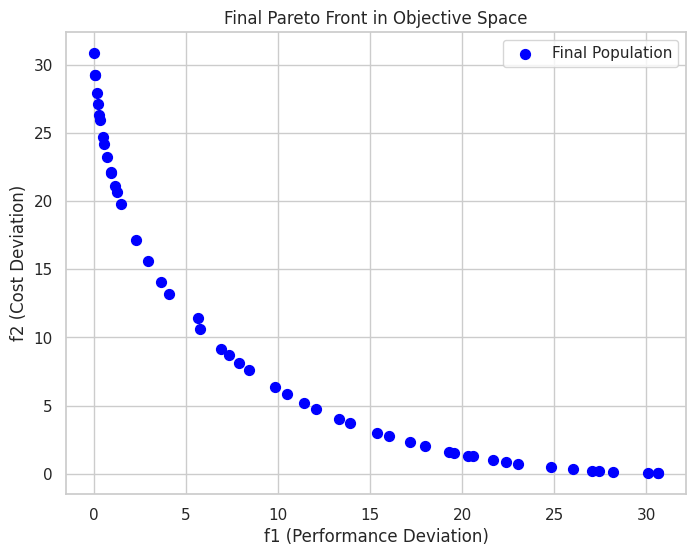

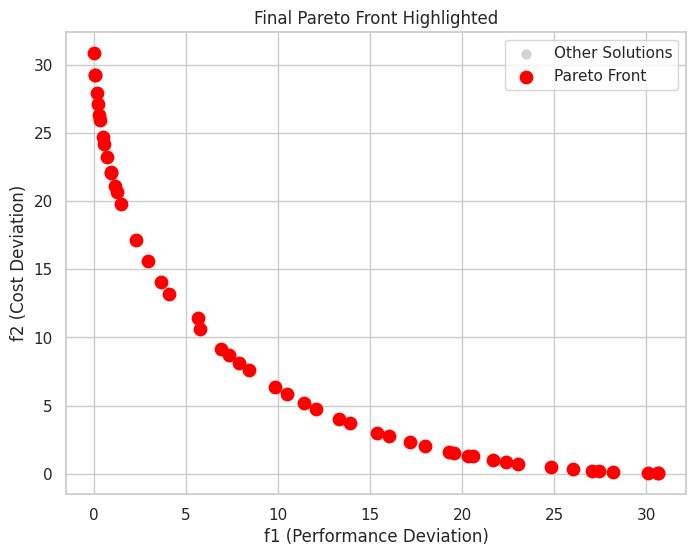

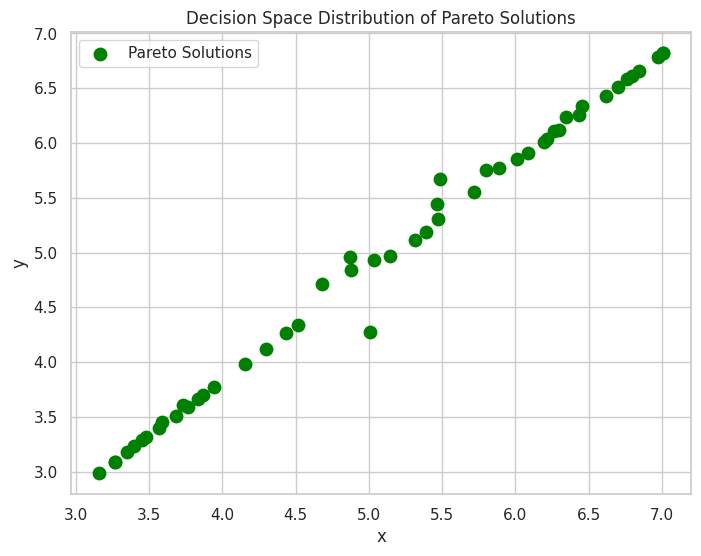

In [10]:
# -----------------------------------------------------------------------------
# 9. Final Pareto Front Visualization in Objective Space and Decision Space
# -----------------------------------------------------------------------------
# Extract objective values for the final population
final_obj = np.array([objectives(ind) for ind in population])
f1_vals = final_obj[:, 0]
f2_vals = final_obj[:, 1]

# Plot the Pareto front in objective space
plt.figure(figsize=(8, 6))
plt.scatter(f1_vals, f2_vals, c='blue', label='Final Population', s=50)
plt.title("Final Pareto Front in Objective Space")
plt.xlabel("f1 (Performance Deviation)")
plt.ylabel("f2 (Cost Deviation)")
plt.legend()
plt.grid(True)
plt.show()

# Identify the non-dominated front of the final combined population
final_fronts = non_dominated_sort(population)
pareto_indices = final_fronts[0]
pareto_objs = np.array([objectives(population[i]) for i in pareto_indices])

plt.figure(figsize=(8, 6))
plt.scatter(f1_vals, f2_vals, c='lightgray', label='Other Solutions', s=40)
plt.scatter(pareto_objs[:, 0], pareto_objs[:, 1], c='red', label='Pareto Front', s=80)
plt.title("Final Pareto Front Highlighted")
plt.xlabel("f1 (Performance Deviation)")
plt.ylabel("f2 (Cost Deviation)")
plt.legend()
plt.grid(True)
plt.show()

# Plot the decision space (x and y values) of the Pareto front
pareto_decisions = np.array([population[i] for i in pareto_indices])
plt.figure(figsize=(8, 6))
plt.scatter(pareto_decisions[:, 0], pareto_decisions[:, 1], c='green', label='Pareto Solutions', s=80)
plt.title("Decision Space Distribution of Pareto Solutions")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

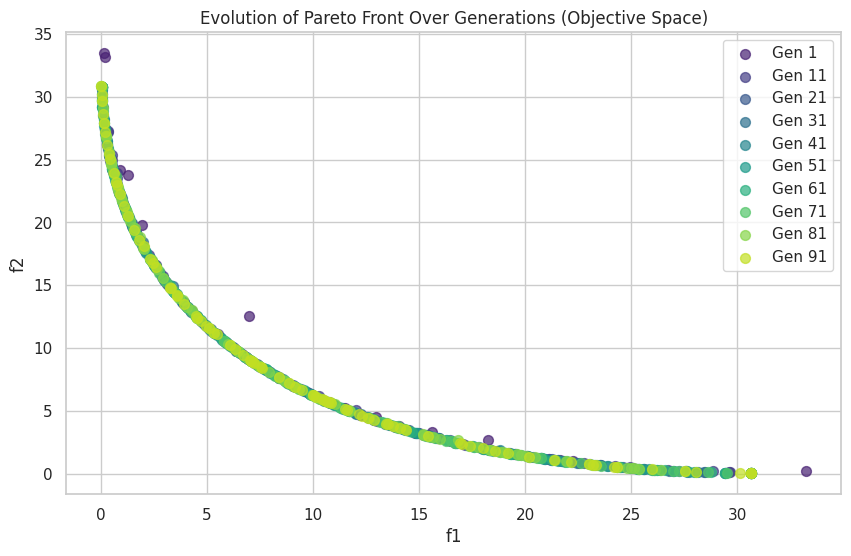

In [11]:
# -----------------------------------------------------------------------------
# 10. Additional Visualization: Evolution of Pareto Front Over Generations
# -----------------------------------------------------------------------------
# For a subset of generations, plot the Pareto front in objective space
plt.figure(figsize=(10, 6))
colors = sns.color_palette("viridis", num_generations//10)
for i, gen in enumerate(range(0, num_generations, 10)):
    front = pareto_front_history[gen]
    front_obj = np.array([objectives(ind) for ind in front])
    plt.scatter(front_obj[:, 0], front_obj[:, 1], color=colors[i], label=f"Gen {gen+1}", s=50, alpha=0.7)
plt.title("Evolution of Pareto Front Over Generations (Objective Space)")
plt.xlabel("f1")
plt.ylabel("f2")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# -----------------------------------------------------------------------------
# 11. Summary of Results
# -----------------------------------------------------------------------------
print("Final Population Size:", len(population))
print("Number of Pareto-optimal Solutions Found:", len(pareto_indices))
print("\nPareto Front (Objective Values):")
for ind in pareto_indices:
    f1, f2 = objectives(population[ind])
    print(f"f1: {f1:.3f}, f2: {f2:.3f}")

# End of Multi-Objective GA NSGA-II Implementation


Final Population Size: 50
Number of Pareto-optimal Solutions Found: 50

Pareto Front (Objective Values):
f1: 30.635, f2: 0.033
f1: 0.026, f2: 30.868
f1: 30.635, f2: 0.033
f1: 5.761, f2: 10.607
f1: 2.941, f2: 15.589
f1: 6.896, f2: 9.188
f1: 2.302, f2: 17.191
f1: 13.340, f2: 4.045
f1: 0.721, f2: 23.220
f1: 0.154, f2: 27.929
f1: 21.696, f2: 1.005
f1: 12.058, f2: 4.772
f1: 17.995, f2: 2.024
f1: 19.272, f2: 1.627
f1: 15.404, f2: 3.001
f1: 5.635, f2: 11.431
f1: 28.187, f2: 0.139
f1: 0.332, f2: 25.946
f1: 24.852, f2: 0.471
f1: 0.480, f2: 24.753
f1: 0.211, f2: 27.174
f1: 1.486, f2: 19.769
f1: 1.142, f2: 21.128
f1: 1.248, f2: 20.682
f1: 20.577, f2: 1.276
f1: 0.078, f2: 29.245
f1: 22.369, f2: 0.879
f1: 26.029, f2: 0.329
f1: 4.103, f2: 13.229
f1: 10.499, f2: 5.875
f1: 9.832, f2: 6.391
f1: 27.027, f2: 0.227
f1: 8.451, f2: 7.592
f1: 7.354, f2: 8.680
f1: 30.121, f2: 0.046
f1: 16.056, f2: 2.731
f1: 0.550, f2: 24.232
f1: 0.078, f2: 29.245
f1: 19.537, f2: 1.551
f1: 11.436, f2: 5.198
f1: 0.290, f2: 26.3